In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

from data.DataUtils import get_ncmapss_dataloaders

import data.datautil as du
from models import TransformerEncoder, TransformerDecoder, StateTransition, RULEstimator

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
trainloader, testloader = get_ncmapss_dataloaders(1, 10, 128, 8, subsampled=True)

In [4]:
columns_excluded = [0, 1, 26] # make sure to mask and THEN take these out
training_features = [True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               False, False, False, False, False, False, False, False, False, False,
               True, True, True, False]


ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X[:,:,training_features].shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 35]), Y Shape: torch.Size([128, 1])


In [6]:
dim = 16

enc = TransformerEncoder(input_dim=ex_X[:,:,training_features].shape[2], embed_dim=dim).to(device)
checkpoint = torch.load(f'./saved_models/enc_ncmapss_{dim}dim.pth')
enc.eval()
enc.load_state_dict(checkpoint['model_state_dict'], strict=False)
enc.positional_embed.data = checkpoint['positional_embed']
for param in enc.parameters():
    param.requires_grad = False

dec = TransformerDecoder(output_dim=ex_X[:,:,training_features].shape[2], embed_dim=dim).to(device)
dec.eval()
dec.load_state_dict(torch.load(f'./saved_models/dec_ncmapss_{dim}dim.pth'))
for param in dec.parameters():
    param.requires_grad = False

steps = 1
trans = StateTransition(embed_dim=dim, hidden_dim=256).to(device)
trans.eval()
trans.load_state_dict(torch.load(f'/home/courseac/projects/autoregressive-rul/saved_models/1step_transition_ncmapss_16d.pth'))
# ./saved_models/{steps}step_transition__ncmapss_{dim}d.pth
for param in trans.parameters():
    param.requires_grad = False
    
rul_est = RULEstimator(embed_dim=dim, hidden_dim=256, dropout=0).to(device)
rul_est.eval()
rul_est.load_state_dict(torch.load(f'./saved_models/rul_ncmapss_16d.pth'))
for param in rul_est.parameters():
    param.requires_grad = False

In [21]:
class RULStepper(nn.Module):
    def __init__(self, enc, trans, rul_est):
        super().__init__()
        self.enc = enc
        self.trans = trans
        self.rul_est = rul_est
        
    def forward(self, x, threshold=1):
        z = self.enc(x)
        ruls = []
        curr_rul = self.rul_est(z) 
        ruls.append(curr_rul.detach().cpu().numpy())
        
        at_eol = curr_rul < threshold
        while not at_eol:
            z = self.trans(z, 1)
            curr_rul = self.rul_est(z)
            print(curr_rul)
            ruls.append(curr_rul.detach().cpu().numpy())
            
            at_eol = curr_rul < threshold
            
        ruls = np.concatenate(ruls)
        return len(ruls), ruls

In [22]:
rulstep = RULStepper(enc, trans, rul_est).to(device)

In [23]:
rulstep(ex_X[0,:,training_features].unsqueeze(0).to(device)) # since N-CMAPSS is so long-term, this doesn't seem like the best idea

tensor([[43.2079]], device='cuda:0')
tensor([[47.3652]], device='cuda:0')
tensor([[50.3394]], device='cuda:0')
tensor([[50.7293]], device='cuda:0')
tensor([[50.7752]], device='cuda:0')
tensor([[50.7895]], device='cuda:0')
tensor([[50.7950]], device='cuda:0')
tensor([[50.7965]], device='cuda:0')
tensor([[50.7969]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
tensor([[50.7971]], device='cuda:0')
t

KeyboardInterrupt: 

In [10]:
def get_prediction_metrics(dataloader, model):
    model.eval()
    predictions = []
    true_labels = []

    threshold = 0.5
    for X, y in dataloader:
        X = X[:,:,training_features].to(torch.float32).to(device)
        target = (y==0).clone().detach().to(torch.float32).to(device).squeeze()

        z = enc(X)
        prob = rul_est(z).squeeze()


        pred = nn.functional.softmax(prob, dim=0)
        pred = (pred > threshold).float()
        predictions.append(pred.detach().cpu().numpy())
        true_labels.append(target.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)

    # Calculate True Positives, True Negatives, False Positives, False Negatives
    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    # Calculate Accuracy, Precision, Recall (True Positive Rate)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)

    plt.plot(predictions)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (True Positive Rate): {recall:.4f}')



In [11]:
# get_prediction_metrics(trainloader, rul_est)

In [12]:
def calc_regression(dataloader, model):
    model.eval()
    predictions = []
    true_ruls = []

    for X, y in dataloader:
        X = X[:,:,training_features].to(torch.float32).to(device)
        y = y.to(torch.float32).to(device).squeeze()

        z = enc(X)
        yhat = model(z).squeeze()

        predictions.append(yhat.detach().cpu().numpy())
        true_ruls.append(y.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    true_ruls = np.concatenate(true_ruls)

    return predictions, true_ruls

In [13]:
rul_est = RULEstimator(dim, 256, 0.25).to(device)
# enc = TransformerEncoder(input_dim=ex_X[:,:,training_features].shape[2], embed_dim=16, dropout=0.11, dim_feedforward=64, n_timesteps=10).to(device)
objective = nn.MSELoss()
optim = torch.optim.Adam(rul_est.parameters(), lr=1e-3)

n_epochs = 3
losses = []
for i in range(n_epochs):
    for X, y in tqdm(trainloader):
        optim.zero_grad()     
        X = X[:,:,training_features].to(torch.float32).to(device)
        y = y.to(torch.float32).to(device).squeeze()

        z = enc(X)
        yhat = rul_est(z).squeeze()
        
        loss = objective(yhat, y)
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
        
    # yhats, ys = calc_regression(testloader, rul_est)
    # rul_est.train()
    # print(np.sqrt(np.mean(np.linalg.norm(yhats-ys))))
    print(f"Epoch: {i+1}, rmse loss: {np.sqrt(np.mean(losses[-100:]))}")

100%|██████████| 3834/3834 [01:01<00:00, 62.06it/s]


Epoch: 1, rmse loss: 5.352128421904856


100%|██████████| 3834/3834 [01:01<00:00, 62.06it/s]


Epoch: 2, rmse loss: 4.92203461306483


100%|██████████| 3834/3834 [01:01<00:00, 62.23it/s]

Epoch: 3, rmse loss: 4.653412121790727


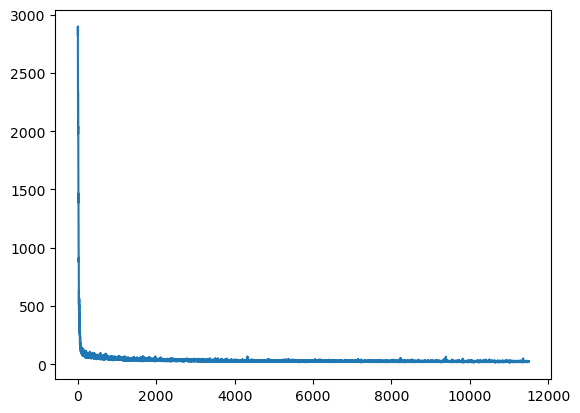

In [14]:
plt.plot(losses)

In [18]:
yhats, ys = calc_regression(trainloader, rul_est)

In [19]:
np.sqrt(np.mean(np.linalg.norm(yhats-ys)))

54.598473

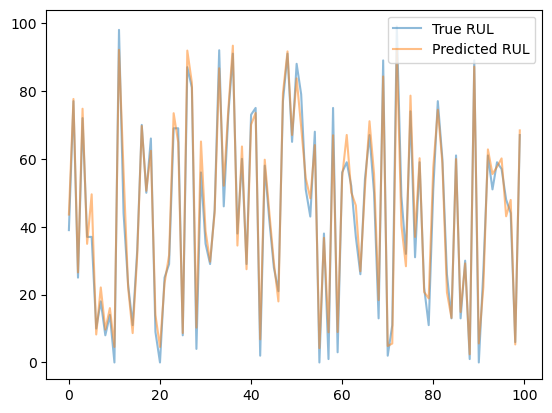

In [25]:
plt.plot(ys[0:100], alpha=0.5, label='True RUL')
plt.plot(yhats[0:100], alpha=0.5, label='Predicted RUL')
plt.legend()

In [26]:
yhats_test, ys_test = calc_regression(testloader, rul_est)

In [62]:
np.sqrt(np.mean(np.square(yhats_test-ys_test)))

27.231518

In [63]:
np.sqrt(np.mean(np.square(yhats_test[0:39000]-ys_test[0:39000])))

8.168642

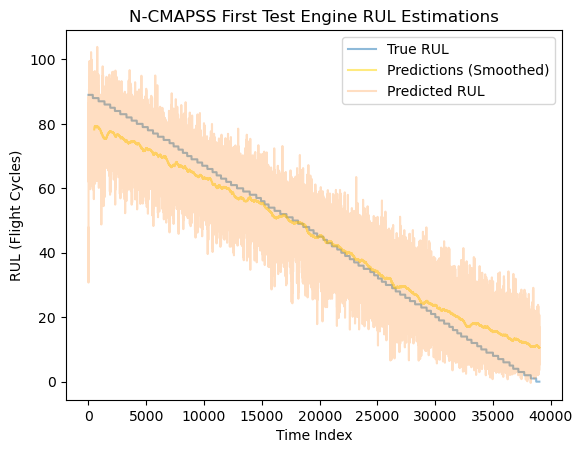

In [51]:
# Calculate rolling mean for predicted RUL
plt.title("N-CMAPSS First Test Engine RUL Estimations")
plt.xlabel("Time Index")
plt.ylabel("RUL (Flight Cycles)")


yhats_test_smoothed = pd.Series(yhats_test).rolling(window=500).mean()

plt.plot(ys_test[0:39000], alpha=0.5, label='True RUL')
plt.plot(yhats_test_smoothed[0:39000], alpha=0.5, label='Predictions (Smoothed)', color='#FFD700')
plt.plot(yhats_test[0:39000], alpha=0.25, label='Predicted RUL')
plt.legend()

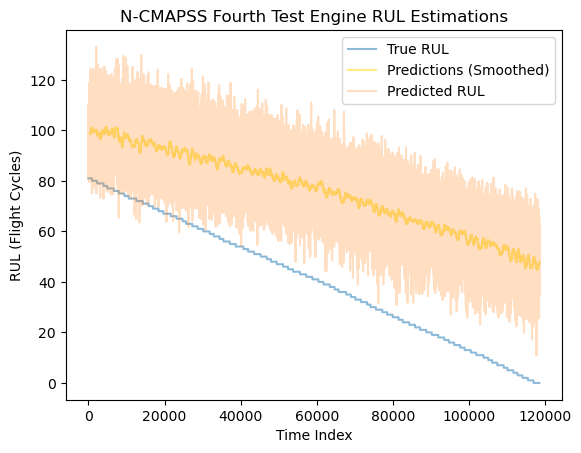

In [58]:
# Calculate rolling mean for predicted RUL
plt.title("N-CMAPSS Fourth Test Engine RUL Estimations")
plt.xlabel("Time Index")
plt.ylabel("RUL (Flight Cycles)")


yhats_test_smoothed = pd.Series(yhats_test[155000:len(ys_test)]).rolling(window=500).mean()

plt.plot(ys_test[155000:len(ys_test)], alpha=0.5, label='True RUL')
plt.plot(yhats_test_smoothed, alpha=0.5, label='Predictions (Smoothed)', color='#FFD700')
plt.plot(yhats_test[155000:len(ys_test)], alpha=0.25, label='Predicted RUL')
plt.legend()

In [60]:
np.sqrt(np.mean(np.square(yhats_test[155000:len(ys_test)]-ys_test[155000:len(ys_test)])))

36.9154

In [32]:
tmp = []
for X, y in tqdm(testloader):
    tmp.append(y.detach().cpu().numpy())

100%|██████████| 2137/2137 [00:33<00:00, 64.20it/s]


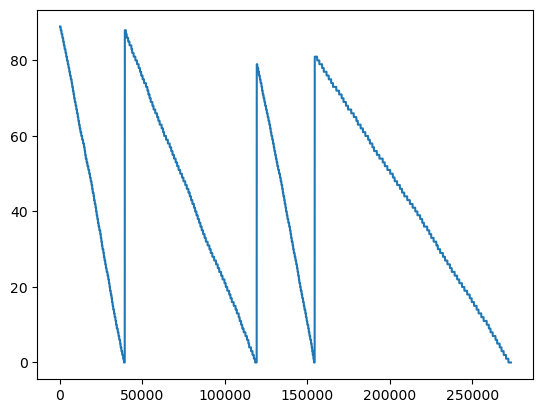

In [37]:
plt.plot(np.vstack(tmp))

In [27]:
# torch.save(rul_est.state_dict(), './saved_models/rul_ncmapss_16d.pth')